In [1]:
import time
t1 = time.time()

import math
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

2025-07-07 08:19:55.284412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
##### load model #####

CNN_model = load_model("/root/data/model_CNN_v1.h5")

##### load image data #####

image_path = "/root/data/test_data_image.h5"
image_file = h5py.File(image_path, 'r')
image_file.keys()

sig_image = image_file['sig_image'][:]
jjBG_image = image_file['jjBG_image'][:]
ttbarBG_image = image_file['ttbarBG_image'][:]

print("signal length", len(sig_image))
print("jjBG length", len(jjBG_image))
print("ttbarBG length", len(ttbarBG_image))

print("Time:", time.time()-t1)

2025-07-07 08:19:58.167668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-07-07 08:19:58.168450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46696 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


signal length 6946
jjBG length 2711
ttbarBG length 5479
Time: 4.615710973739624


In [3]:
##### predict test data #####

sig_predict = CNN_model.predict(sig_image)
ttbarBG_predict = CNN_model.predict(ttbarBG_image)
jjBG_predict = CNN_model.predict(jjBG_image)

2025-07-07 08:20:00.382819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


 71/218 [========>.....................] - ETA: 0s

2025-07-07 08:20:01.066988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


85/85 [==============================] - 0s 3ms/step


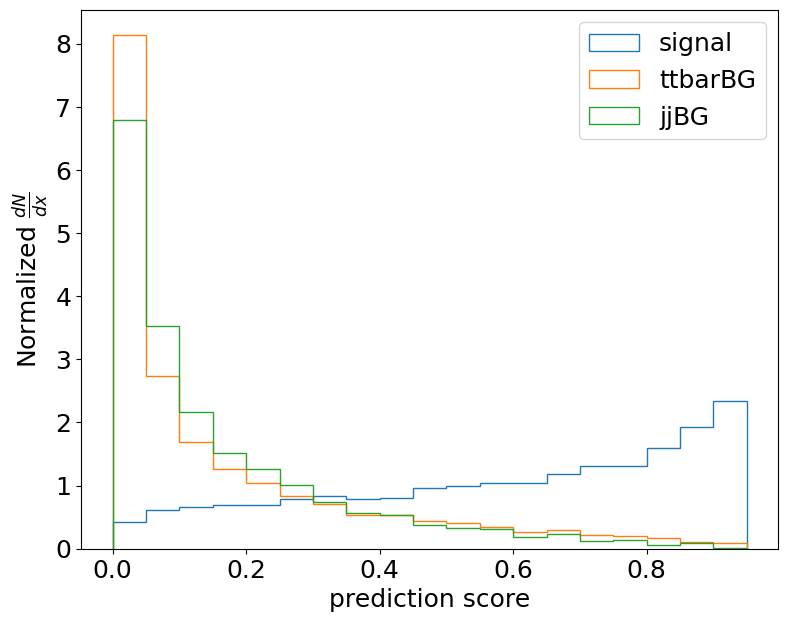

In [4]:
##### plot the prediction histogram #####

plt.figure(1, figsize=(9,7))
bins = np.arange(0,1,0.05)
plt.hist(sig_predict, bins=bins, label="signal", histtype='step', density=True)
plt.hist(ttbarBG_predict, bins=bins, label="ttbarBG", histtype='step', density=True)
plt.hist(jjBG_predict, bins=bins, label="jjBG", histtype='step', density=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"prediction score", fontsize=18)
plt.ylabel(r"Normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

In [5]:
##### CNN selection #####
score_cut = 0.8

sig_selected = len(sig_predict[np.where(sig_predict>score_cut)])
ttbarBG_selected = len(ttbarBG_predict[np.where(ttbarBG_predict>score_cut)])
jjBG_selected = len(jjBG_predict[np.where(jjBG_predict>score_cut)])

print(sig_selected, "signal event pass CNN score", score_cut)
print(ttbarBG_selected, "ttbarBG event pass CNN score", score_cut)
print(jjBG_selected, "jjBG event pass CNN score", score_cut)

print("\nNote that the total test events is 10000.\n")

##### calculate significance in Luminosity = 3000(fb^-1) #####

N_sim_sig = 10000
N_sim_ttbarBG = 10000
N_sim_jjBG = 10000

Xsection_sig = 1.1086583
print("Before selection, the cross section of signal:", Xsection_sig, "(fb)")
Xsection_ttbarBG = 34166.61
print("Before selection, the cross section of ttbarBG:", Xsection_ttbarBG, "(fb)")
Xsection_jjBG = 60561410.45
print("Before selection, the cross section of jjBG:", Xsection_jjBG, "(fb)")

Luminosity = 3000    ### unit:fb^-1
print("\nIn Luminosity = 3000(fb^-1)")

s = Xsection_sig * (sig_selected/N_sim_sig) * Luminosity
b = Xsection_ttbarBG * (ttbarBG_selected/N_sim_ttbarBG) * Luminosity + Xsection_jjBG * (jjBG_selected/N_sim_jjBG) * Luminosity
significance = np.sqrt(2*((s+b)*np.log(1+s/b)-s))
print("significance:", significance)

2602 signal event pass CNN score 0.8
107 ttbarBG event pass CNN score 0.8
24 jjBG event pass CNN score 0.8

Note that the total test events is 10000.

Before selection, the cross section of signal: 1.1086583 (fb)
Before selection, the cross section of ttbarBG: 34166.61 (fb)
Before selection, the cross section of jjBG: 60561410.45 (fb)

In Luminosity = 3000(fb^-1)
significance: 0.04139249310977223
